In [1]:
using PauliPropagation
using Plots
using Logging
using Statistics
using LinearAlgebra
using GLM
using StatsModels
using LsqFit
using Distributions
using Format
using DataFrames
using CSV
using LaTeXStrings

In [2]:
function run_or_read(model, circuit, nq, nl, tstep, obs_i, obs_j, max_weight, min_abs_coeff; run=false)
    fn = format("data/{}_nq={:d}_nl={:d}_theta={:.3e}_obsi={:d}_obsj={:d}_maxweight={:d}_minabscoeff={:.4e}.dat", model, nq, nl, tstep, obs_i, obs_j, max_weight, min_abs_coeff)
    expectation = 0
    observable = PauliString(nq, [:Z,:Z], [obs_i,obs_j]);
    time = range(tstep, tstep*nl, nl)
    try
        @assert run==false
        open(fn, "r") do log
            data = CSV.read(log, DataFrame)
            time_file = data[!,1]
            expectation = data[!,2]
        end
    catch e
        expectation = thermalStateExpectation(circuit, nl, nq, observable; min_abs_coeff=min_abs_coeff, max_weight=max_weight)
        data = DataFrame(time=time, expectation=expectation)
        CSV.write(fn, data)
    end
    return expectation
end

run_or_read (generic function with 1 method)

In [3]:
function jordan_wigner_tfim(n_sites::Int, Jx::Float64=1.0, Jy::Float64=1.0, h::Float64=1.0)
    """
    Construct the Bogoliubov-de Gennes matrix for the Ising model:

    Args:
        n_sites (Int): Number of sites
        J (Float64): Coupling strength for σ^x σ^x interaction
        h (Float64): Transverse field strength

    Returns:
        Matrix{Float64}: 2n_sites × 2n_sites BdG matrix
    """
    J = Jx+Jy
    k = (Jx-Jy)/J
    A = zeros(Float64, n_sites, n_sites)
    B = zeros(Float64, n_sites, n_sites)

    for i in 1:(n_sites-1)
        A[i, i] = h
        A[i+1, i+1] = h
    end

    for i in 1:(n_sites-1)
        A[i, i+1] = -J/2
        A[i+1, i] = -J/2
    end

    for i in 1:(n_sites-1)
        B[i, i+1] = -J*k/2
        B[i+1, i] = J*k/2
    end

    M = [A  B;
        -B -A]

    return M
end

function zz_correlation(M::Matrix{Float64}, beta::Float64, i::Int, j::Int)
    N = size(M, 1) ÷ 2

    eigvals, eigvecs = eigen(Hermitian(M))

    # Extract u and v components
    Uk = eigvecs[1:N, :]
    Vk = eigvecs[N+1:end, :]

    # Thermal occupations
    f = 1.0 ./ (exp.(2 * beta .* eigvals) .+ 1.0)
    f_diag = Diagonal(f)

    G = Uk * f_diag * Uk'
    F = Uk * f_diag * Vk'

    zz = 4 * (G[i,i] - 0.5) * (G[j,j] - 0.5) - 4 * G[i,j] * G[j,i] + 4 * abs2(F[i,j])

    return zz
end

zz_correlation (generic function with 1 method)

In [9]:
function zte_exp(expvals, truncs, times; plotting=true, exact_expvals=nothing, abs_threshold=1e-16)
    try
        @assert length(expvals)==length(truncs)
    catch e
        error("The length of input arguments don't match (length(expvals)=$(length(expvals)), length(truncs)=$(length(truncs)))")
    end
    corrected_expvals = Vector{Float64}()
    for idx=1:length(expvals[1])
        expvals_t = [row[idx] for row in expvals]
        # data = DataFrame(trunc=truncs, expval=expvals_t)
        push!(corrected_expvals, exp_fit(truncs, expvals_t; abs_threshold=abs_threshold))
    end
    if plotting
        truncated_most_precise = expvals[end]
        try
            @assert length(times)==length(corrected_expvals)==length(truncated_most_precise)
        catch e
            error("The lengths don't match for plotting (length(times)=$(length(times)), length(corrected_expvals)=$(length(corrected_expvals)))")
        end
        p = plot(times, corrected_expvals, label="corrected")
        plot!(times, truncated_most_precise, label="truncated most precise")
        plot!(yscale=:log10)
        xlabel!("Timestep")
        ylabel!("Observable")
        title!("Evolution over time")
        if exact_expvals!=nothing
            plot!(times, exact_expvals, label="exact")
            q = plot(times, abs.(corrected_expvals-exact_expvals)./exact_expvals, label="corrected")
            plot!(times, abs.(truncated_most_precise-exact_expvals)./exact_expvals, label="truncated most precise")
            plot!(yscale=:log10)
            xlabel!("Timestep")
            ylabel!("Relative error")
            title!("Evolution over time")
            display(q)
        end
        display(p)
    end
    return corrected_expvals
end

function exp_fit(xdata, ydata; abs_threshold=1e-16)
    mask = xdata .>= abs_threshold
    xdata = xdata[mask]
    ydata = ydata[mask]
    model(x, p) = p[1] .+ p[2] .* exp.(-p[3] .* x)
    p0 = [ydata[end], ydata[1] - ydata[end], 1.0]
    fit = curve_fit(model, xdata, ydata, p0)
    return model(0.0, fit.param)
end

exp_fit (generic function with 1 method)

# TFIM

In [4]:
theta = 0.01im
θ = theta
nq = 30

topology = bricklayertopology(nq)

# the circuit
circuitTFIM = Gate[]
nl = 1
for i in 1:nl
    #append!(circuitTFIM, PauliRotation(:X, ii, θ) for ii in 1:nq);
    append!(circuitTFIM, PauliRotation(:Z, ii, θ) for ii in 1:nq);
    append!(circuitTFIM, PauliRotation([:X, :X], pair, θ) for pair in topology);
end


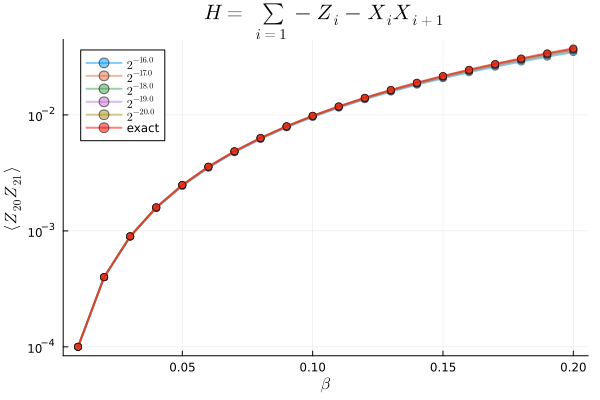

In [5]:
# system parameters
obs_i = 21
obs_j = 20
observable = PauliString(nq, [:Z,:Z], [obs_i,obs_j])

nl = 20
max_weight = 9 #6
trunc_coeffs = 2.0 .^ (-16:-1:-20)

tstep = 0.01
time = range(tstep, tstep*nl, nl)

# initialize the plot
plot(ylabel=L"$\langle Z_{20}Z_{21} \rangle$", xlabel=L"\beta", title = L"$H = \sum_{i=1} -Z_i - X_iX_{i+1}$")

# exact expectation values calculations
M = jordan_wigner_tfim(nq, 1.0, 0.0, 1.0)
zz = zeros(length(time))
for i in 1:length(time)
    zz[i] = zz_correlation(M, time[i], obs_i, obs_j)
end

# get truncated expectation values
expvals = Vector{Vector{Float64}}()
for j in trunc_coeffs
    expectation = run_or_read("TFIM", circuitTFIM, nq, nl, tstep, obs_i, obs_j, max_weight, j)
    plot!(time, expectation, label = L"$2^{%$(round(log2(j), digits=2))}$", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
    push!(expvals, expectation)
end
plot!(yscale=:log10)
plot!(time, zz, label = "exact", color="red", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)


display(plot!())

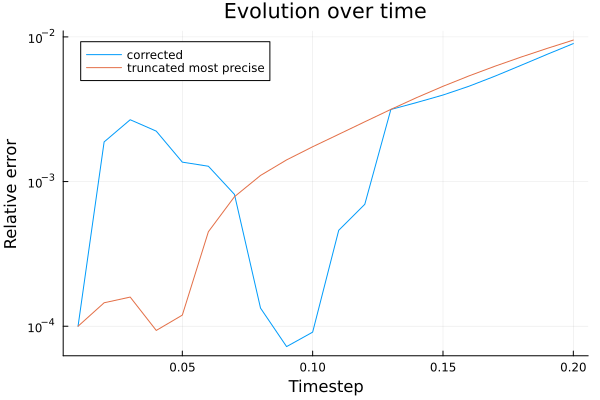

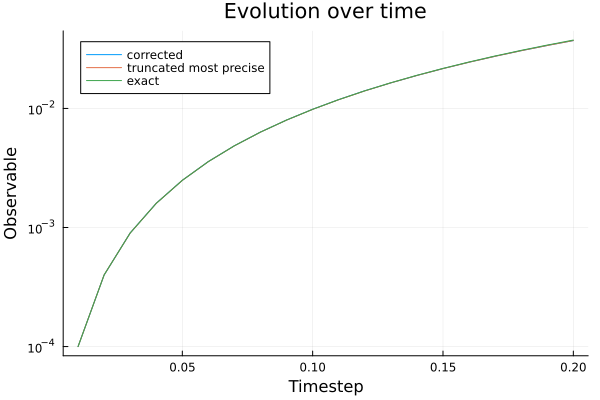

In [11]:
zte_exp(expvals, trunc_coeffs, time; exact_expvals=zz);